In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils as ku 
import pickle
import logging

from generators import PasswordBatchGenerator
from data_preparation import construct_subsequences, ff_labels, rnn_labels, add_spaces, transform_password, pad_and_tokenize
from predict_utils import predict_letter, predict_next_letter, predict_password

print(tf.keras.__version__)
tf.test.gpu_device_name()

2023-01-22 15:21:40.547693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


2023-01-22 15:21:44.962954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/device:GPU:0'

2023-01-22 15:21:45.227929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:21:45.249552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:21:45.249854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:21:46.564838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:21:46.565894: I tensorflow/compile

In [3]:
#!pip install pandas
#!pip install --timeout=10000 matplotlib
#!pip install pydot
#!pip install tensorflow-text
#!pip install joblib

In [4]:
try:
    with open('data.pkl', 'rb') as file:
        df = pickle.load(file)
except:
    # Load the Password list into Memory
    url = "https://raw.githubusercontent.com/danielmiessler/SecLists/master/Passwords/Common-Credentials/10-million-password-list-top-1000000.txt"

    df_in = pd.read_csv(url, header=None)

    df = transform_password(df_in)
    with open('data.pkl', 'wb') as file:
        # Cache Data
        pickle.dump(df, file)

In [5]:
limit = len(df)
sequences = construct_subsequences(df, limit=len(df))

/app/data_preparation.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for row in df[:limit]:


In [6]:
from keras.preprocessing.text import Tokenizer

#We us a Tokenizer to code each Letter into a number

tokenizer  = Tokenizer(filters=None, char_level=True, lower=False)
tokenizer.fit_on_texts(sequences)

# Translation from Word to Token and back
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = len(word2idx) + 1

In [7]:
# The one hot matrix is nice, but we don't need that
#1. get max password length

max_length = max([len(x) for x in sequences])

In [8]:
tok_sequence = pad_and_tokenize(sequences, tokenizer, max_length)

In [9]:
predictors, label = ff_labels(tok_sequence, vocab_size)

In [10]:
# Init generator
batch_size= 10_000
training_batch = PasswordBatchGenerator(predictors, label, batch_size)

In [11]:
try:
  with open(f'/app/models/ff_model_{str(limit)}.pkl', 'rb') as file:
      ff_model = pickle.load(file)
      logging.info(ff_model.summary())
except:# FileNotFoundError:
  ff_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(vocab_size,), activation="sigmoid"),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  ff_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  ff_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/ff_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(ff_model, file)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-01-22 15:15:40           64
config.json                                    2023-01-22 15:15:40         1402
variables.h5                                   2023-01-22 15:15:40       315912
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12416     
                                                    

2023-01-22 15:22:52.045080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:22:52.046113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:22:52.046477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:22:52.048729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 15:22:52.049042: I tensorflow/compile

1/1 [==============================] - 1s 1s/step


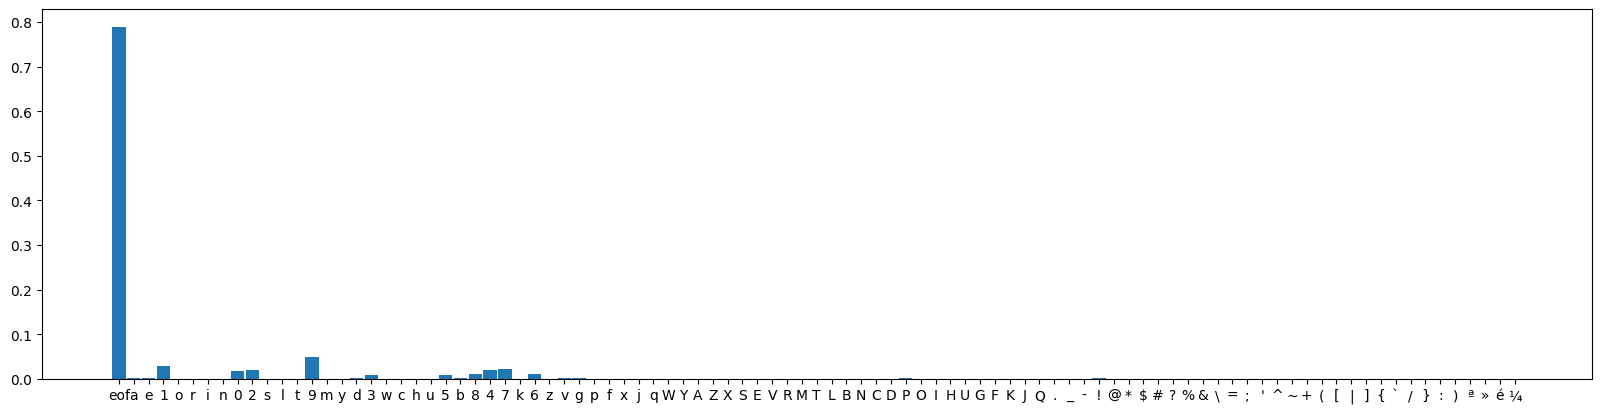

1/1 [==============================] - 0s 26ms/step


'FGD'

In [12]:
predict_next_letter("LOV", ff_model, tokenizer, True)
predict_password("FGD", ff_model, tokenizer )

In [13]:
logging.info(ff_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12416     
                                                                 
 dense_1 (Dense)             (None, 96)                12384     
                                                                 
Total params: 24,800
Trainable params: 24,800
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Split the Data into trainset and labels

predictors, label = rnn_labels(tok_sequence, vocab_size)

In [15]:
# Init generator
batch_size= 10_000
training_batch = PasswordBatchGenerator(predictors, label, batch_size)

In [16]:
try:
  with open(f'/app/models/rnn_model_{str(limit)}.pkl', 'rb') as file:
      rnn_model = pickle.load(file)
      logging.info(rnn_model.summary())
except FileNotFoundError:
  rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10, input_length=max_length-1), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.SimpleRNN(100), # skips masked timesteps
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  rnn_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  rnn_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/rnn_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(rnn_model, file)

Epoch 1/100


2023-01-22 15:23:03.351531: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5a6c010420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-22 15:23:03.351609: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-01-22 15:23:03.410948: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-22 15:23:03.907506: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


653/653 [==============================] - 120s 177ms/step - loss: 3.1962
Epoch 2/100
653/653 [==============================] - 110s 169ms/step - loss: 2.9175
Epoch 3/100
653/653 [==============================] - 115s 175ms/step - loss: 2.8800
Epoch 4/100
653/653 [==============================] - 112s 172ms/step - loss: 2.9017
Epoch 5/100
653/653 [==============================] - 119s 181ms/step - loss: 2.8481
Epoch 6/100
653/653 [==============================] - 119s 182ms/step - loss: 2.8329
Epoch 7/100
653/653 [==============================] - 116s 177ms/step - loss: 2.8213
Epoch 8/100
653/653 [==============================] - 117s 179ms/step - loss: 2.8104
Epoch 9/100
653/653 [==============================] - 120s 184ms/step - loss: 2.8021
Epoch 10/100
653/653 [==============================] - 119s 183ms/step - loss: 2.7943
Epoch 11/100
653/653 [==============================] - 117s 180ms/step - loss: 2.7865
Epoch 12/100
653/653 [==============================] - 120s 184

In [17]:
try:
  with open(f'/app/models/lstm_model_{str(limit)}.pkl', 'rb') as file:
      lstm_model = pickle.load(file)
      logging.info(lstm_model.summary())
except:
  lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 10, input_length=max_length-1), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.LSTM(100), # skips masked timesteps
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
  ])
  lstm_model.compile(
                #optimizer='rmsprop',
                loss='categorical_crossentropy',
                optimizer='adam')

  lstm_model.fit( training_batch , epochs=100, verbose=1)

  # cache the model
  with open(f'/app/models/lstm_model_{str(limit)}.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(lstm_model, file)


Epoch 1/100


2023-01-22 18:28:50.450325: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2023-01-22 18:28:53.382473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


653/653 [==============================] - 152s 219ms/step - loss: 3.3096
Epoch 2/100
653/653 [==============================] - 138s 211ms/step - loss: 2.9525
Epoch 3/100
653/653 [==============================] - 138s 211ms/step - loss: 2.9037
Epoch 4/100
653/653 [==============================] - 143s 219ms/step - loss: 2.8758
Epoch 5/100
653/653 [==============================] - 143s 220ms/step - loss: 2.8523
Epoch 6/100
653/653 [==============================] - 171s 262ms/step - loss: 2.8268
Epoch 7/100
653/653 [==============================] - 165s 252ms/step - loss: 2.8047
Epoch 8/100
653/653 [==============================] - 167s 255ms/step - loss: 2.7879
Epoch 9/100
653/653 [==============================] - 155s 238ms/step - loss: 2.7749
Epoch 10/100
653/653 [==============================] - 148s 227ms/step - loss: 2.7619
Epoch 11/100
653/653 [==============================] - 155s 237ms/step - loss: 2.7514
Epoch 12/100
653/653 [==============================] - 152s 233

In [18]:

# https://stackoverflow.com/questions/43341374/tensorflow-dynamic-rnn-lstm-how-to-format-input
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
# https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275
# https://ai.stackexchange.com/questions/18198/what-is-the-difference-between-lstm-and-rnn#:~:text=The%20main%20difference%20between%20an%20LSTM%20unit%20and,better%20the%20flow%20of%20information%20through%20the%20unit.


In [19]:
import pickle

# pickle model
with open('/root/model.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(lstm_model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......masking
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-01-22 22:24:24           64
config.json                                    2023-01-22 22:24:24         2466
variables.h5                                   2023-01-22 22:24:24       687008


1/1 [==============================] - 0s 34ms/step


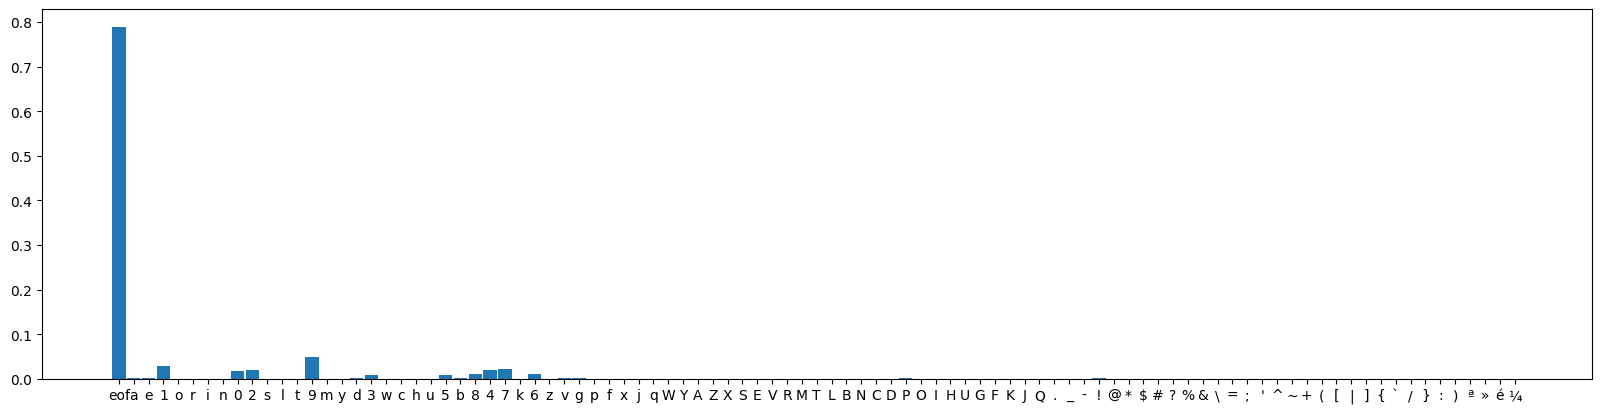

1/1 [==============================] - 0s 42ms/step


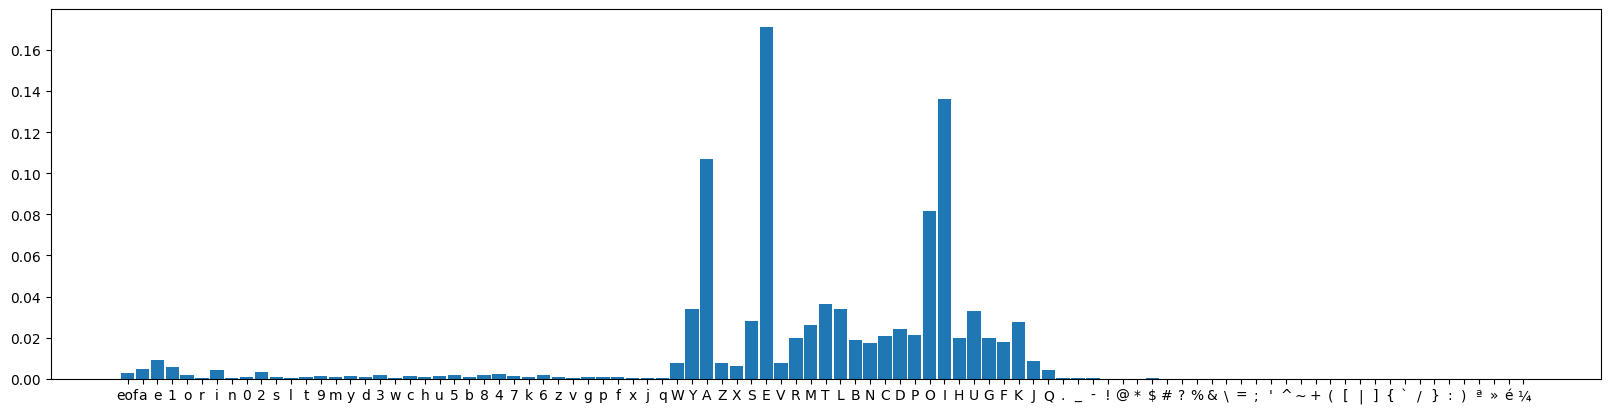

1/1 [==============================] - 0s 42ms/step


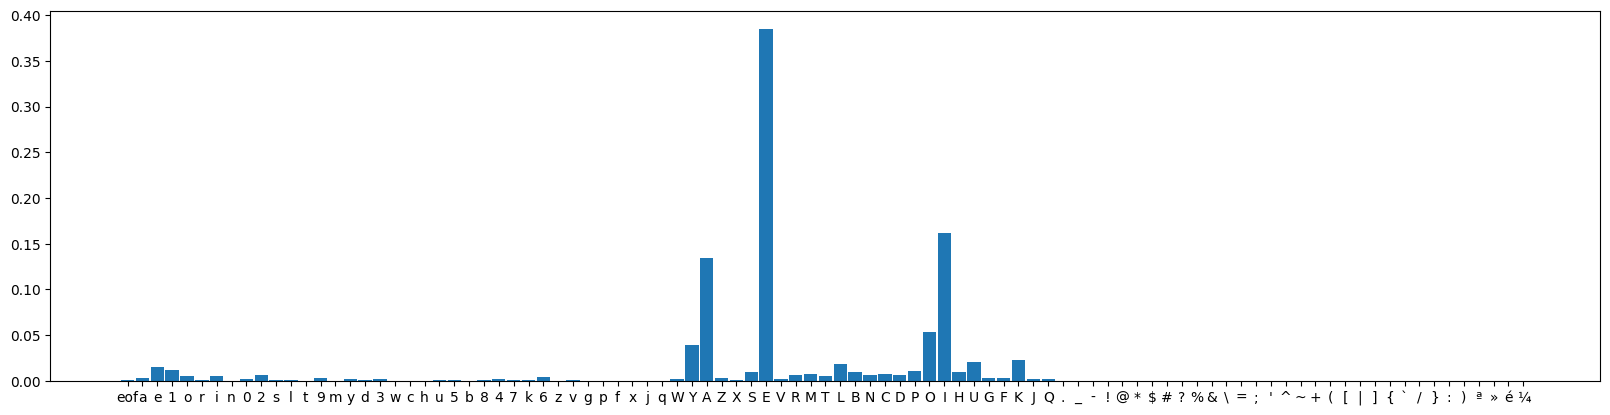

'E'

In [26]:
predict_next_letter("LOV", ff_model, tokenizer, True)
predict_next_letter("LOV", rnn_model, tokenizer, True)
predict_next_letter("LOV", lstm_model, tokenizer, True)

In [67]:
print( predict_password("batm", rnn_model, tokenizer) )
print( predict_password("batm", lstm_model, tokenizer) )

1/1 [==============================] - 0s 33ms/step
batmac21
1/1 [==============================] - 0s 36ms/step
batmangov


In [23]:
#https://jhui.github.io/2017/03/15/RNN-LSTM-GRU/
#https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
#https://www.kaggle.com/code/namansood/nlp-guide-next-word-prediction-and-deep-learning